In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

TypeError: 'type' object is not subscriptable

In [2]:
sammypath = "/Users/colefritsch/GitLab/Sammy/sammy/build/bin/sammy"

In [3]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [4]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair()      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=8.79,
                       gn2_avg=465,
                       gn2_dof=1,
                       gg2_avg=350,
                       gg2_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model()


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        Print        = True,
                                        bayes        = False,
                                        keep_runDIR  = True,
                                        sammy_runDIR = 'sammy_runDIR_1')

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')



In [5]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()

synOPT = syndatOPT(calculate_covariance=True, explicit_covariance=True)

synT = Syndat_Model(
              exp_model_T,
              generative,
              reductive,
              synOPT)
## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

In [6]:
vars(generative.model_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]]),
 'open_neutron_spectrum':                tof            bw    ct        dct           E
 0    183110.960936  9.999999e-08  1190  34.496377  200.200037
 1    183010.960948  9.999998e-08  1213  34.828150  200.422933
 2    182910.960963  1.000001e-07  1242  35.242020  200.646202
 3    182810.960863  9.999996e-08  1182  34.380227  200.869845
 4    182710.960904  1.000001e-07  1214  34.842503  201.093861
 ..             ...           ...   ...        ...         ...
 184  164710.960895  9.999999e-08  1298  36.027767  248.453308
 185  164610.960907  9.999995e-08  1349  36.728735  248.761496
 186  164510.960956  1.000000e-07  1293  35.958309  24

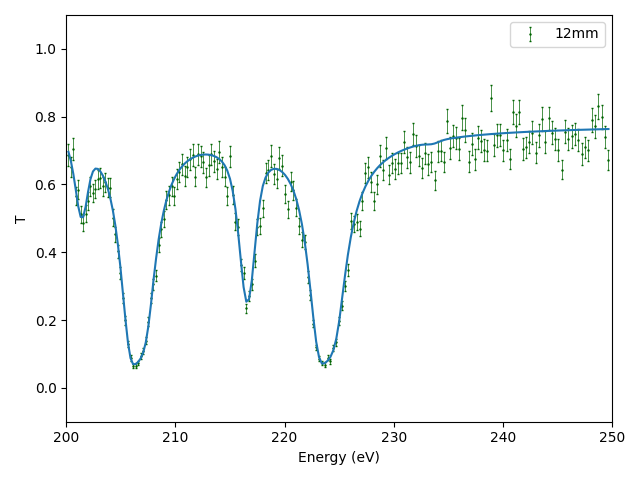

In [7]:
datasample = synT.samples[0]
data = datasample.pw_reduced


figure()
errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
plot(data.E, data.true)
ylabel("T")

xlim([200,250])
ylim([-0.1,1.1])
legend()
xlabel('Energy (eV)')
tight_layout()

In [8]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
# filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [9]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'Cov_sys', 'Jac_sys', 'diag_stat'])


In [10]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001023,0.000266,0.000287,0.000231,0.000239,0.000209,0.000199,0.000210,0.000225,0.000243,...,0.000298,0.000281,0.000289,0.000286,0.000322,0.000314,0.000338,0.000326,0.000302,0.000274
200.422933,0.000266,0.000928,0.000273,0.000220,0.000227,0.000199,0.000189,0.000199,0.000213,0.000231,...,0.000283,0.000267,0.000274,0.000271,0.000306,0.000298,0.000321,0.000309,0.000287,0.000260
200.646202,0.000287,0.000273,0.001064,0.000237,0.000245,0.000215,0.000204,0.000215,0.000230,0.000249,...,0.000305,0.000288,0.000296,0.000293,0.000330,0.000322,0.000347,0.000334,0.000309,0.000281
200.869845,0.000231,0.000220,0.000237,0.000719,0.000197,0.000173,0.000164,0.000173,0.000185,0.000200,...,0.000246,0.000232,0.000239,0.000236,0.000266,0.000259,0.000279,0.000269,0.000249,0.000226
201.093861,0.000239,0.000227,0.000245,0.000197,0.000783,0.000178,0.000170,0.000179,0.000191,0.000207,...,0.000254,0.000240,0.000246,0.000243,0.000274,0.000268,0.000288,0.000278,0.000257,0.000234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000314,0.000298,0.000322,0.000259,0.000268,0.000235,0.000223,0.000236,0.000252,0.000272,...,0.000334,0.000315,0.000324,0.000320,0.000361,0.001149,0.000379,0.000365,0.000339,0.000307
248.761496,0.000338,0.000321,0.000347,0.000279,0.000288,0.000253,0.000240,0.000254,0.000271,0.000293,...,0.000360,0.000340,0.000349,0.000345,0.000389,0.000379,0.001343,0.000393,0.000365,0.000331
249.070258,0.000326,0.000309,0.000334,0.000269,0.000278,0.000243,0.000231,0.000244,0.000261,0.000282,...,0.000346,0.000327,0.000336,0.000332,0.000374,0.000365,0.000393,0.001309,0.000351,0.000319
249.379595,0.000302,0.000287,0.000309,0.000249,0.000257,0.000226,0.000214,0.000226,0.000242,0.000262,...,0.000321,0.000303,0.000312,0.000308,0.000347,0.000339,0.000365,0.000351,0.001081,0.000295


In [11]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [12]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

161469.0
854.332


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

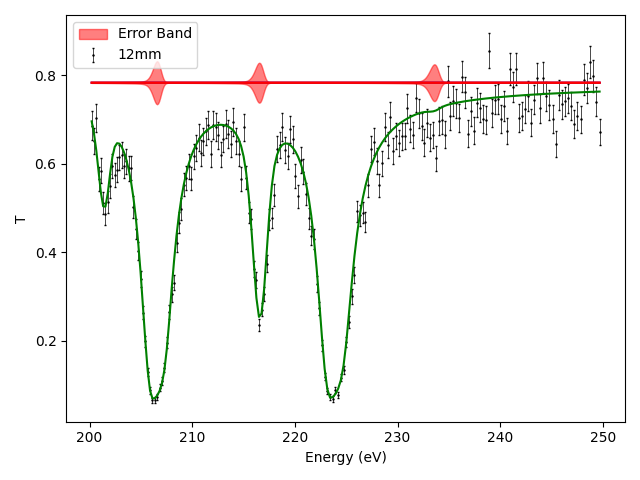

In [13]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [14]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  201.360058  682.471382  0.000010    1.0     1.0      1.0   1.0
1  206.489864    0.000009  0.000010    1.0     1.0      1.0   1.0
2  216.442431    0.000010  0.000010    1.0     1.0      1.0   1.0
3  223.800651  645.325222  0.000012    1.0     1.0      1.0   1.0
4  233.490790    0.000009  0.000010    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

In [15]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,201.360058,682.471382,0.000010,1.0,1.0,1.0,1.0,341.235691,0.000199,3.0,0.0
1,206.489864,0.000009,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000197,3.0,0.0
2,216.442431,0.000010,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000190,3.0,0.0
3,223.800651,645.325222,0.000012,1.0,1.0,1.0,1.0,322.662611,0.000220,3.0,0.0
4,233.490790,0.000009,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000184,3.0,0.0


In [16]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [17]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [18]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [19]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [20]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [21]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")